In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Inizializzazione dati

In [2]:
data = pd.read_csv("./data/dataset_utente_3.txt",header=None)

In [3]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,30.0,2019,0,1,0,1,1004,12,43,0
1,1,1,0,12.0,2019,1,1,0,0,354,2,24,0
2,2,2,1,10.0,2018,0,0,0,0,400,8,29,0
3,3,3,0,12.0,2019,1,0,0,0,340,2,35,0
4,4,4,0,12.0,2018,1,0,0,0,252,4,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,116,50,12,15.0,2018,13,0,1,1,500,8,26,0
117,117,50,12,16.0,2018,13,0,1,1,600,18,39,0
118,118,50,12,14.0,2018,13,0,1,1,600,14,31,0
119,119,50,12,15.0,2018,13,0,1,1,600,15,38,0


In [4]:
features = data

In [5]:
labels = data[12]

In [6]:
n_clusters = 3

# Definizione Pipeline

In [7]:
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=2, random_state=0)),
    ]
)

In [8]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="random",
               n_init=50,
               max_iter=300,
               random_state=0,
           ),
       ),
       (
           "dbscan",
           DBSCAN(eps=0.3)
       ),       
   ]
)

In [9]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [10]:
pipe.fit(features)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=0))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(init='random', n_clusters=3, n_init=50,
                                         random_state=0)),
                                 ('dbscan', DBSCAN(eps=0.3))]))])

In [11]:
preprocessed_data = pipe["preprocessor"].transform(features)

In [12]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_
predicted_labels_DB = pipe["clusterer"]["dbscan"].labels_

In [13]:
silhouette_score(preprocessed_data, predicted_labels)

0.3978327487551547

In [14]:
silhouette_score(preprocessed_data, predicted_labels_DB)

-0.11964472337335649

In [15]:
adjusted_rand_score(labels, predicted_labels)

0.008709306040733993

In [16]:
adjusted_rand_score(labels, predicted_labels_DB)

0.014586761648146063

# Visualizzazione risultati

In [17]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(features),
    columns=["component_1", "component_2"],
)
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = labels

c:\users\grazi\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


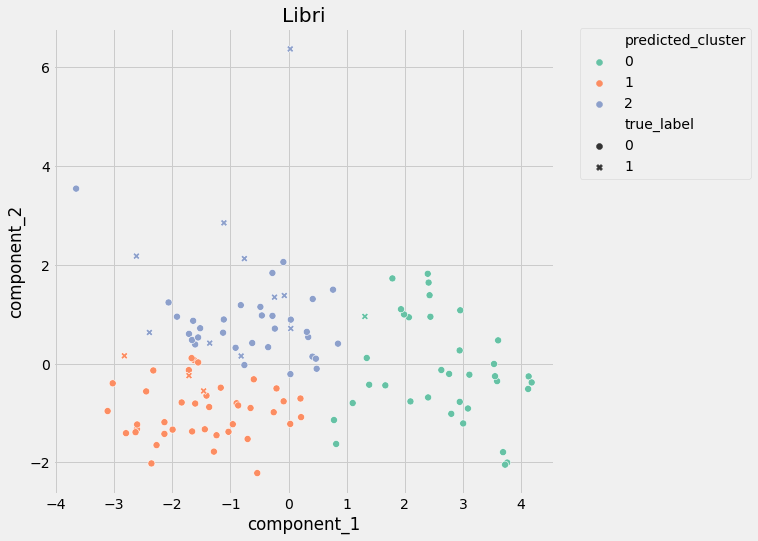

In [18]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Libri"
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [19]:
result = data
result['cluster'] = pcadf["predicted_cluster"]

# Metriche di valutazione della suddivisione in cluster

In [20]:
silhouette_scores = []
ari_scores = []
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(features)
    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(features),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        labels,
        pipe["clusterer"]["kmeans"].labels_,
    )
    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)


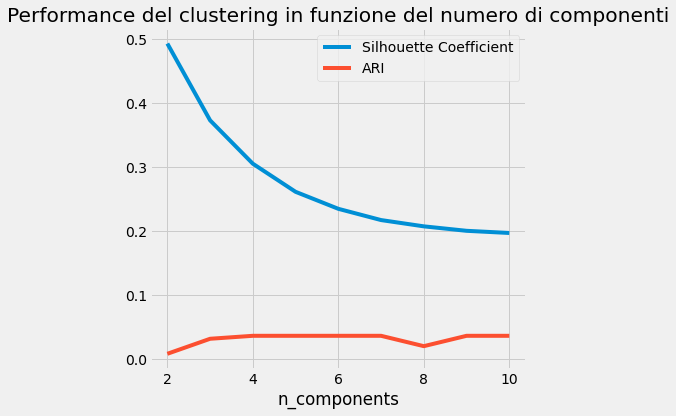

In [21]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 11),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 11), ari_scores, c="#fc4f30", label="ARI")
plt.xlabel("n_components")
plt.legend()
plt.title("Performance del clustering in funzione del numero di componenti")
plt.tight_layout()
plt.show()

# Output consigli 

In [22]:
def find_cluster_max():
    group_by_cluster = data.groupby(by="cluster").sum()
    return group_by_cluster[12].idxmax()

In [23]:
data.groupby(by="cluster").sum()

,0,1,2,3,4,5,6,7,8,9,10,11,12
cluster,,,,,,,,,,,,,
0,3572,2110,654,488.2,72609,397,1,33,23,8993,350,903,1
1,1308,811,82,555.5,86742,168,13,5,4,13742,333,1048,3
2,2380,1381,222,764.4,84771,217,21,11,21,21010,423,1314,10


In [24]:
find_cluster_max()

2

In [25]:
cluster_max = result[result['cluster'] == find_cluster_max()]

In [26]:
libri = pd.read_csv('./data/libri.csv')
consigli = libri[libri.index.isin(cluster_max.index)]

In [27]:
utente4 = pd.read_csv("./data/utente_3.txt", header=None)

In [28]:
result[result[12] == 0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,cluster
0,0,0,0,30.0,2019,0,1,0,1,1004,12,43,0,2
1,1,1,0,12.0,2019,1,1,0,0,354,2,24,0,1
2,2,2,1,10.0,2018,0,0,0,0,400,8,29,0,1
3,3,3,0,12.0,2019,1,0,0,0,340,2,35,0,1
4,4,4,0,12.0,2018,1,0,0,0,252,4,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,116,50,12,15.0,2018,13,0,1,1,500,8,26,0,0
117,117,50,12,16.0,2018,13,0,1,1,600,18,39,0,0
118,118,50,12,14.0,2018,13,0,1,1,600,14,31,0,0
119,119,50,12,15.0,2018,13,0,1,1,600,15,38,0,0


In [29]:
consigli = consigli.join(result)

In [30]:
consigli[consigli[12] == 1]

,ISBN,Titolo,Autore,Editore,Prezzo,Anno,Nome_Categoria,storia_vera,illustrato,saga,...,4,5,6,7,8,9,10,11,12,cluster
15,9788245335872,L isola di Arturo,Elsa Morante,Einaudi,13.0,2019,Narrativa italiana,0,0,0,...,2019,1,0,0,0,400,17,44,1,2
34,9788804670520,Il mondo nuovo,Aldous Huxley,Mondadori,14.0,2016,Fantascienza,0,0,1,...,2016,6,0,0,1,355,0,38,1,2
43,9788804726685,Il tempo della clemenza,John Grisham,Mondadori,22.0,2020,Thriller,0,0,1,...,2020,9,0,0,1,640,18,38,1,2
44,9788804727880,Illuminismo adesso,Steven Pinker,Mondadori,18.0,2020,Saggistica,1,0,0,...,2020,4,1,0,0,700,14,25,1,2
66,9788820067748,Pet Sematary,Stephen King,Sperling & Kupfer,20.0,2019,Horror,0,0,0,...,2019,7,0,0,0,400,14,28,1,2
69,9788822719713,La guerra dei mondi,G.W. Wells,Newton Compton Editore,4.9,2018,Fantascienza,0,0,0,...,2018,6,0,0,0,452,7,49,1,2
72,9788830104716,Il Signore degli Anelli,J.R.R. Tolkien,Bompiani,50.0,2020,Fantasy,0,1,1,...,2020,13,0,1,1,1000,5,29,1,2
76,9788834738955,La svastica sul sole,Philip K. Dick,Fanucci Editore,16.0,2019,Fantascienza,0,0,0,...,2019,6,0,0,0,453,0,21,1,2
84,9788845298752,Homo Deus,Yuval Noah Harari,Bompiani,16.0,2018,Saggistica,1,0,1,...,2018,4,1,0,1,500,6,35,1,2
85,9788845932984,Essere una macchina.,Mark O Connell,Adelphi,19.0,2018,Saggistica,1,0,0,...,2018,4,1,0,0,430,12,6,1,2


In [31]:
consigli = consigli[consigli[12] == 0]

In [32]:
consigli.ISBN.to_csv("./data/risultati_utente_3.txt", header=None)

In [33]:
consigli

,ISBN,Titolo,Autore,Editore,Prezzo,Anno,Nome_Categoria,storia_vera,illustrato,saga,...,4,5,6,7,8,9,10,11,12,cluster
0,9781245562344,Alla ricerca del tempo perduto,Marcel Proust,Mondadori,30.0,2019,Narrativa straniera,1,0,1,...,2019,0,1,0,1,1004,12,43,0,2
17,9788345645731,Spagna,AAVV,Lonely Planet,20.0,2016,Viaggi,1,1,0,...,2016,2,1,1,0,300,17,39,0,2
19,9788523645731,Corea,AAVV,Lonely Planet,20.0,2019,Viaggi,1,1,0,...,2019,2,1,1,0,300,9,45,0,2
20,9788674345731,India,AAVV,Lonely Planet,20.0,2020,Viaggi,1,1,0,...,2020,2,1,1,0,300,16,44,0,2
21,9788804325645,Roma,AAVV,Lonely Planet,20.0,2019,Viaggi,1,1,0,...,2019,2,1,1,0,300,9,38,0,2
26,9788804662648,Lo scudo di Talos,Valerio Massimo Manfredi,Mondadori,14.0,2016,Narrativa storica,1,0,1,...,2016,5,1,0,1,563,14,47,0,2
27,9788804664994,Ciclo delle Fondazioni. Prima Fondazione-Fonda...,Isaac Asimov,Mondadori,16.0,2017,Fantascienza,0,0,1,...,2017,6,0,0,1,800,5,13,0,2
30,9788804666905,Alexandros. La trilogia,Valerio Massimo Manfredi,Mondadori,17.0,2016,Narrativa storica,1,0,1,...,2016,5,1,0,1,700,7,37,0,2
36,9788804676379,Storie della buonanotte per bambine ribelli. 1...,Favilli/Cavallo,Mondadori,20.0,2017,Ragazzi,1,1,1,...,2017,3,1,1,1,300,1,48,0,2
38,9788804688846,Storie della buonanotte per bambine ribelli 2,Favilli/Cavallo,Mondadori,20.0,2018,Ragazzi,1,1,1,...,2018,3,1,1,1,300,5,7,0,2
